In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import datasets

In [3]:
from datasets import Features, Value, ClassLabel
from datasets import load_dataset, Image

class_names = ['image']
ft = Features({'image': Image(decode=True, id=None), 'label': ClassLabel(names=['625819a92a2466ab6181a2fb5271ae99c740b4f0e4b9bc97bcfa01ef4ed9666f', '739a87d55867610f9341b5706e0702effaca6404b58a85184530e97674925c11', '912b0ea8f91a77c03100a11b064c6352c96b157402b302f1d4e2fdd0b19ca0da', 'c130f98c73856f51a8a5d53d5566171b4f3b2b64b733b9392b3a4c4387af0208', 'ca0306348357abce2f22db92a9d60f3c7d65a4b6a94e9f8b596b33c0bb41d22c'], id=None)})

dataset = load_dataset("DucHaiten/PIXAR-SDXL", features=ft)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1851 [00:00<?, ? examples/s]

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1851
    })
})

In [19]:
train_dataset = dataset['train']

In [20]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1851
})

In [21]:
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
transform = transforms.Resize((1024,1024))

class PixarDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.asarray(item["image"]).astype(np.float32)/255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        image = transform(image)
        return image

In [22]:
trainDataset = PixarDataset(dataset=train_dataset)

In [23]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(trainDataset, batch_size=8, shuffle=True)

In [24]:
import torch
import torch.nn as nn

In [45]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=(1, 1), kernel_size=(5, 5),     padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(3, 3), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(3, 3), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(5, 5), padding=1)
        )

        # Decoder
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(3, 3), kernel_size=(5, 5), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(3, 3), kernel_size=(5, 5), padding=0, output_padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 3, stride=(1, 1), kernel_size=(5, 5), padding=0),
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encoding(self, x):
        x = self.encoder(x)
        return x

    def decode(self, x):
        x = self.decoder(x)
        return x

In [26]:
model = Autoencoder().cuda()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
train_loss_history = []

for epoch in range(500):
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_dataloader):
        images = data
        images = images.cuda()
        labels = images.cuda()
        optimizer.zero_grad()
        predicted_labels = model(images) ## forward pass
        fit = loss(predicted_labels, labels)  ## calculate loss
        fit.backward() ## backprop
        optimizer.step()  ## calculate gradients and updates weights
        train_loss += fit.item()

    train_loss = train_loss/len(train_dataloader)
    train_loss_history.append(train_loss)

    print(f'Epochs {epoch}, Train loss: {train_loss}')

    if train_loss<0.001:
        break

Epochs 0, Train loss: 0.029875540298987823
Epochs 1, Train loss: 0.016944549719859234
Epochs 2, Train loss: 0.015868049016591675
Epochs 3, Train loss: 0.015322151318882945
Epochs 4, Train loss: 0.01405541622682057
Epochs 5, Train loss: 0.012897516593762577
Epochs 6, Train loss: 0.012312931856160565
Epochs 7, Train loss: 0.011694211631226513
Epochs 8, Train loss: 0.010928151672926796
Epochs 9, Train loss: 0.008585712095172594
Epochs 10, Train loss: 0.006890784126128359
Epochs 11, Train loss: 0.006118978363168747
Epochs 12, Train loss: 0.005738023028243333
Epochs 13, Train loss: 0.005281530773760912
Epochs 14, Train loss: 0.00478871489106276
Epochs 15, Train loss: 0.00421328505637638
Epochs 16, Train loss: 0.003613374895739353
Epochs 17, Train loss: 0.0035782825236373326
Epochs 18, Train loss: 0.0036207319499226287
Epochs 19, Train loss: 0.0034392490029106207
Epochs 20, Train loss: 0.003159651642912148
Epochs 21, Train loss: 0.003209459716062752
Epochs 22, Train loss: 0.00329665367738424

In [ ]:
torch.save(model.state_dict(), 'model.pt')

[]

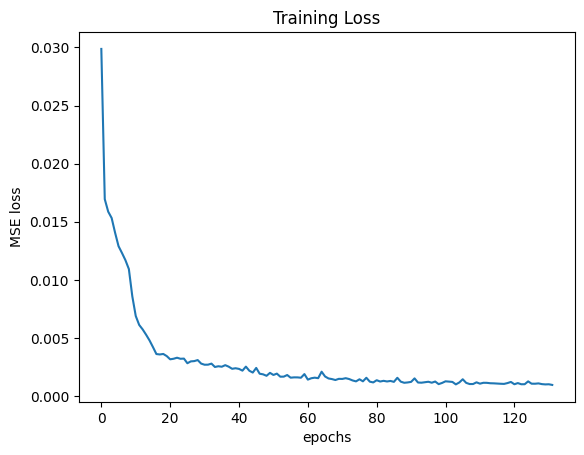

In [52]:
plt.plot(train_loss_history)
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("Training Loss")
plt.plot()

### Inference

In [27]:
model.load_state_dict(torch.load("/content/model.pt"))

<All keys matched successfully>

In [28]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(3, 3), output_padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1))
    (7): Sigmoid()
  )
)

In [29]:
import matplotlib.pyplot as plt

(-0.5, 1023.5, 1023.5, -0.5)

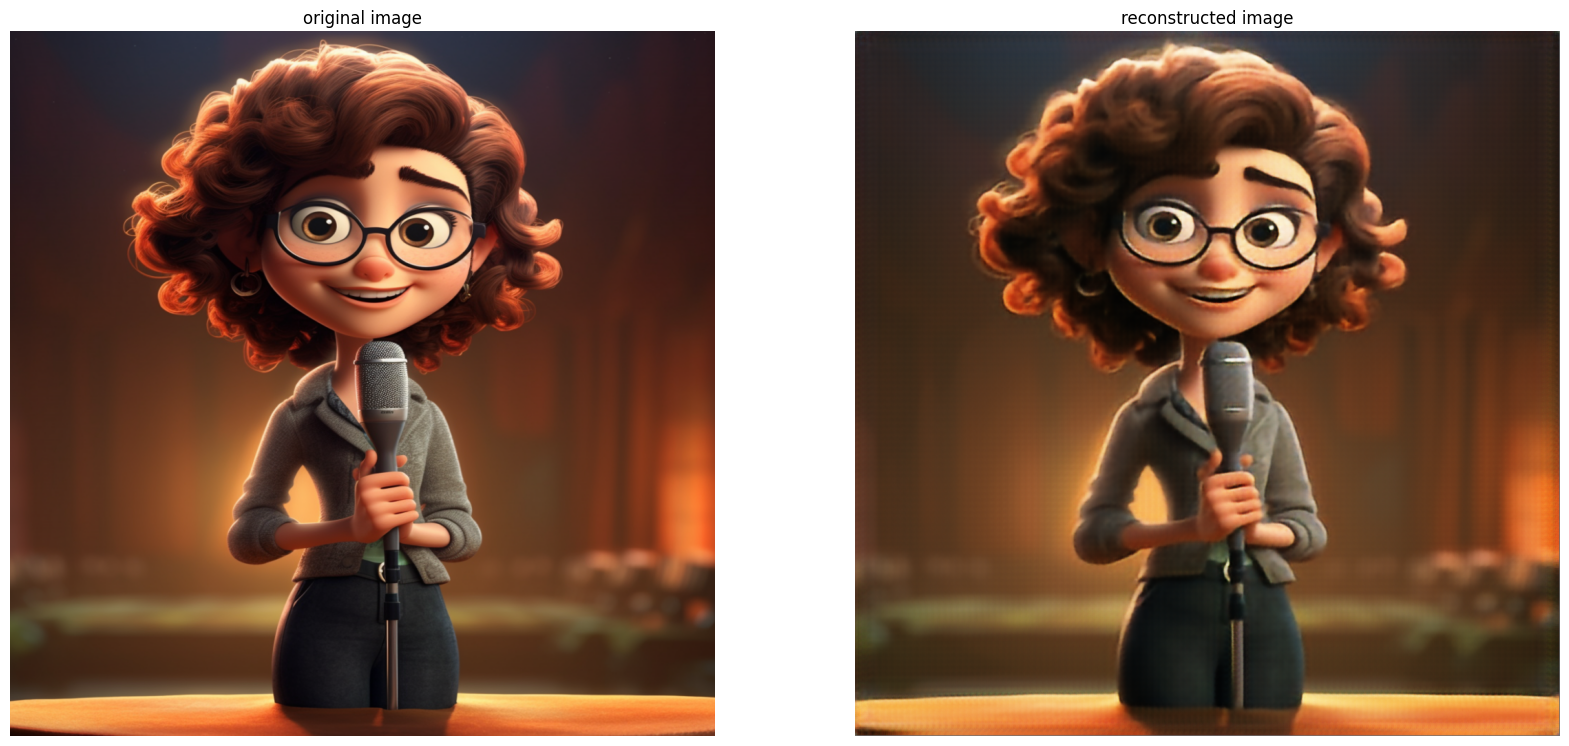

In [42]:
image = trainDataset[14]
image = image.cuda()
reconstructed = model(image)

orig_image = (255*(image.permute(1,2,0))).cpu().numpy()
orig_image = orig_image.astype('uint8')
recon_image = (255*(reconstructed.permute(1,2,0))).cpu().detach().numpy()
recon_image = recon_image.astype('uint8')

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(orig_image)
plt.title("original image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(recon_image)
plt.title("reconstructed image")
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

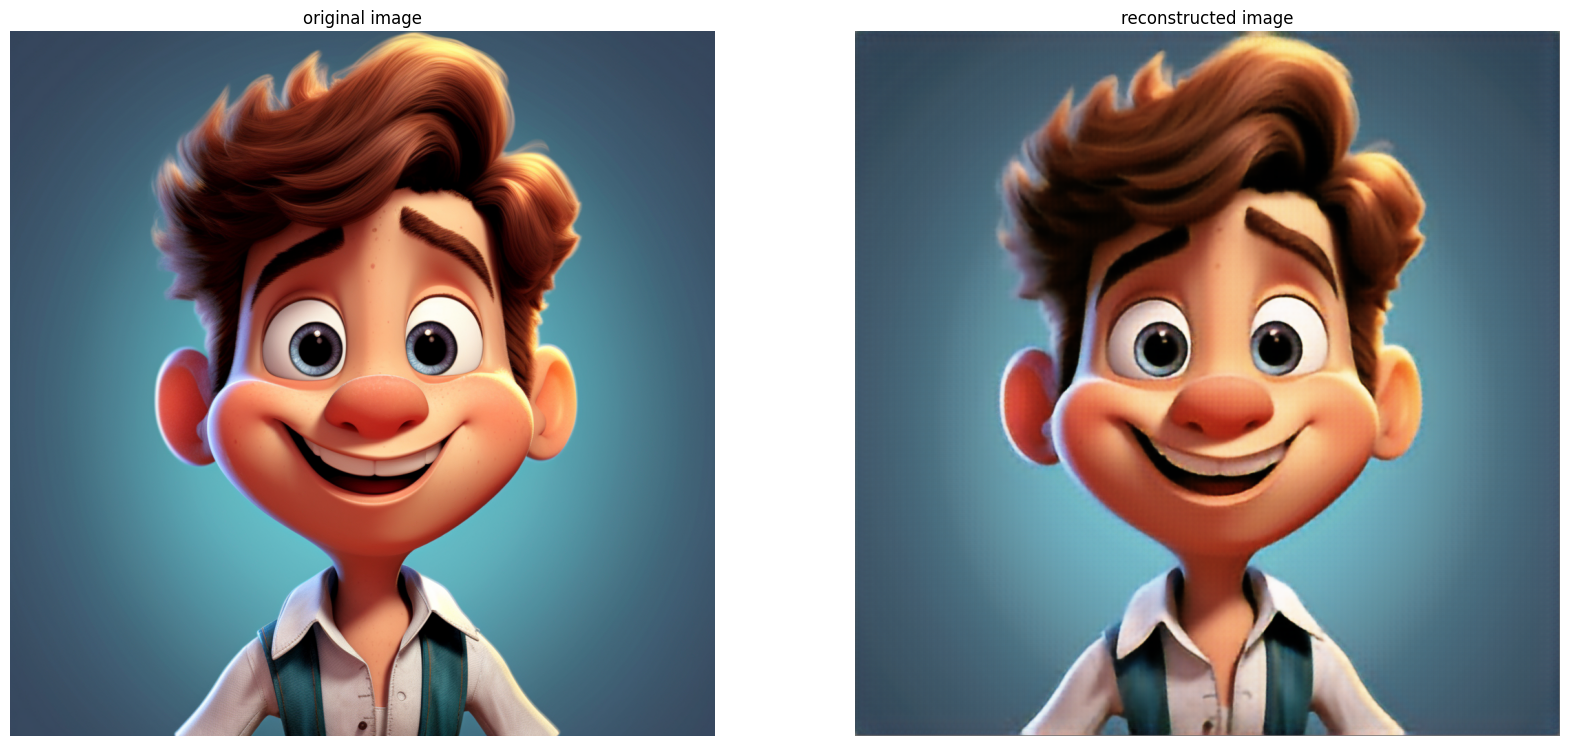

In [43]:
image = trainDataset[10]
image = image.cuda()
reconstructed = model(image)

orig_image = (255*(image.permute(1,2,0))).cpu().numpy()
orig_image = orig_image.astype('uint8')
recon_image = (255*(reconstructed.permute(1,2,0))).cpu().detach().numpy()
recon_image = recon_image.astype('uint8')

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(orig_image)
plt.title("original image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(recon_image)
plt.title("reconstructed image")
plt.axis('off')